# **Part 3: Model Training and Evaluation**

This part focuses on:
- Model training with hyperparameter tuning
- Model comparison and evaluation
- SHAP analysis for interpretability
- Feature importance analysis
- Business insights and recommendations

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           roc_curve)
import xgboost as xgb
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('Libraries imported successfully!')
print('MODEL TRAINING AND EVALUATION')
print('=' * 30)

Libraries imported successfully!
MODEL TRAINING AND EVALUATION


## 1. Load Preprocessed Data

Load the preprocessed data from Part 2 (Data Preprocessing notebook).

In [6]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract components
X_train_balanced = data['X_train_balanced']
X_test_scaled = data['X_test_scaled']
y_train_balanced = data['y_train_balanced']
y_test = data['y_test']
feature_columns = data['feature_columns']

print(f'Training set shape: {X_train_balanced.shape}')
print(f'Test set shape: {X_test_scaled.shape}')
print(f'Number of features: {len(feature_columns)}')
print(f'Training set churn rate: {y_train_balanced.mean():.2%}')
print(f'Test set churn rate: {y_test.mean():.2%}')

Training set shape: (4248, 24)
Test set shape: (630, 24)
Number of features: 24
Training set churn rate: 50.00%
Test set churn rate: 15.71%


## 2. Background Impact Analysis

**Research Question 2**: How does customer background information impact churn prediction accuracy?

In [9]:
# Define feature groups for background impact analysis
feature_groups = {
    'Usage Only': [
        'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
        'Distinct Called Numbers', 'usage_efficiency', 'communication_diversity',
        'usage_intensity'
    ],
    'Background Only': [
        'Age', 'Tariff Plan', 'Status', 'Customer Value',
        'Subscription  Length', 'Charge  Amount', 'Complains',
        'Call  Failure', 'complaint_failure_ratio', 'value_tenure_ratio'
    ],
    'Combined Features': feature_columns
}

background_results = {}

for group_name, features in feature_groups.items():
    # Get feature indices
    feature_indices = [i for i, col in enumerate(feature_columns) if col in features]
    X_group_train = X_train_balanced[:, feature_indices]
    X_group_test = X_test_scaled[:, feature_indices]
    
    # Train simple logistic regression
    lr_temp = LogisticRegression(random_state=42, max_iter=1000)
    lr_temp.fit(X_group_train, y_train_balanced)
    
    # Evaluate
    y_pred = lr_temp.predict(X_group_test)
    y_prob = lr_temp.predict_proba(X_group_test)[:, 1]
    
    background_results[group_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }

print('\n BACKGROUND IMPACT RESULTS:')
print('=' * 30)
for group, metrics in background_results.items():
    print(f'\n{group}:')
    for metric, value in metrics.items():
        print(f'  {metric.capitalize()}: {value:.4f}')


 BACKGROUND IMPACT RESULTS:

Usage Only:
  Accuracy: 0.6540
  Precision: 0.2836
  Recall: 0.7879
  F1: 0.4171
  Auc: 0.8084

Background Only:
  Accuracy: 0.8429
  Precision: 0.5000
  Recall: 0.8788
  F1: 0.6374
  Auc: 0.9077

Combined Features:
  Accuracy: 0.8587
  Precision: 0.5312
  Recall: 0.8586
  F1: 0.6564
  Auc: 0.9400


## 3. Model Training with Hyperparameter Tuning

**Research Question 3**: Can we improve churn prediction by combining usage patterns with personal profiles?

In [11]:
# Define models with hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
    }
}

print('MODEL TRAINING WITH HYPERPARAMETER TUNING:')
print('=' * 40)

MODEL TRAINING WITH HYPERPARAMETER TUNING:


In [12]:
# Train and tune models
tuned_models = {}
tuned_results = {}

for name, model_info in models.items():
    print(f'\n Tuning {name}...')
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model_info['model'], 
        model_info['params'], 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Best model
    best_model = grid_search.best_estimator_
    tuned_models[name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    tuned_results[name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'y_pred': y_pred,
        'y_prob': y_prob,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f' {name} completed - AUC: {tuned_results[name]["auc"]:.4f}')


🔧 Tuning Logistic Regression...
 Logistic Regression completed - AUC: 0.9462

🔧 Tuning Random Forest...
 Random Forest completed - AUC: 0.9861

🔧 Tuning XGBoost...
 XGBoost completed - AUC: 0.9900


## 4. Model Comparison and Evaluation

In [20]:
# Performance comparison table
comparison_df = pd.DataFrame({
    name: {
        'CV Score': results['cv_score'],
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1'],
        'AUC': results['auc']
    }
    for name, results in tuned_results.items()
}).round(4)

print(' TUNED MODEL PERFORMANCE COMPARISON:')
print('=' * 60)
print(comparison_df)

# Find best model
best_model_name = max(tuned_results.keys(), key=lambda x: tuned_results[x]['auc'])
best_model = tuned_models[best_model_name]
best_results = tuned_results[best_model_name]

print(f'\n🏆 BEST MODEL: {best_model_name}')
print(f'AUC Score: {best_results["auc"]:.4f}')
print(f'Best Parameters: {best_results["best_params"]}')

 TUNED MODEL PERFORMANCE COMPARISON:
           Logistic Regression  Random Forest  XGBoost
CV Score                0.9510         0.9962   0.9975
Accuracy                0.8587         0.9603   0.9683
Precision               0.5301         0.8627   0.8762
Recall                  0.8889         0.8889   0.9293
F1-Score                0.6642         0.8756   0.9020
AUC                     0.9462         0.9861   0.9900

🏆 BEST MODEL: XGBoost
AUC Score: 0.9900
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}


## 5. Model Performance Visualizations

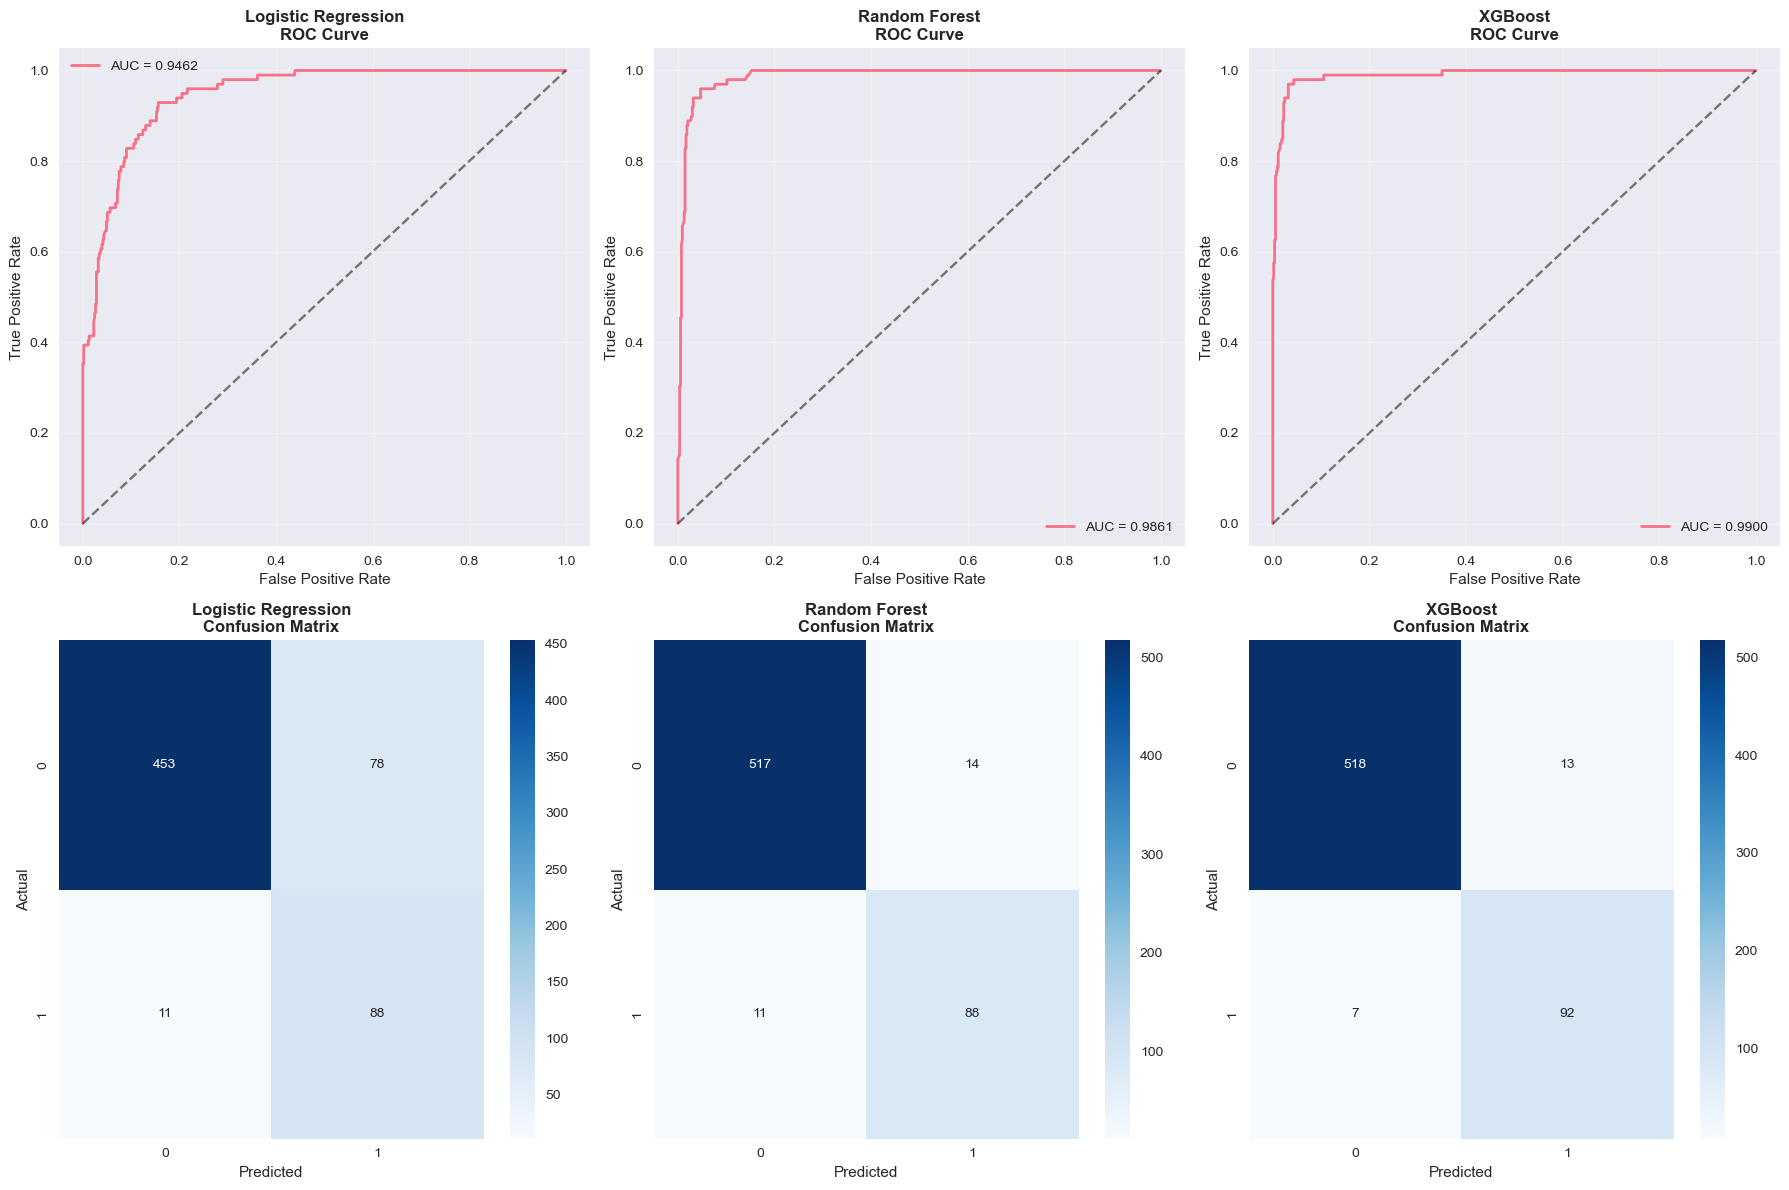

In [23]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ROC Curves
for i, (name, results) in enumerate(tuned_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['y_prob'])
    axes[0, i].plot(fpr, tpr, linewidth=2, label=f'AUC = {results["auc"]:.4f}')
    axes[0, i].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, i].set_title(f'{name}\nROC Curve', fontweight='bold')
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# Confusion Matrices
for i, (name, results) in enumerate(tuned_results.items()):
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, i])
    axes[1, i].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 6. SHAP Analysis for Model Interpretability

In [25]:
# SHAP Analysis for the best model
print('SHAP ANALYSIS FOR MODEL INTERPRETABILITY:')
print('=' * 60)

# Sample data for SHAP (to avoid memory issues)
sample_size = min(100, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]

# Create SHAP explainer for the best model
if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
elif best_model_name == 'Random Forest':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # For binary classification, take positive class
else:  # Logistic Regression
    explainer = shap.LinearExplainer(best_model, X_train_balanced)
    shap_values = explainer.shap_values(X_test_sample)

print(f' SHAP analysis completed for {best_model_name}')

SHAP ANALYSIS FOR MODEL INTERPRETABILITY:
 SHAP analysis completed for XGBoost


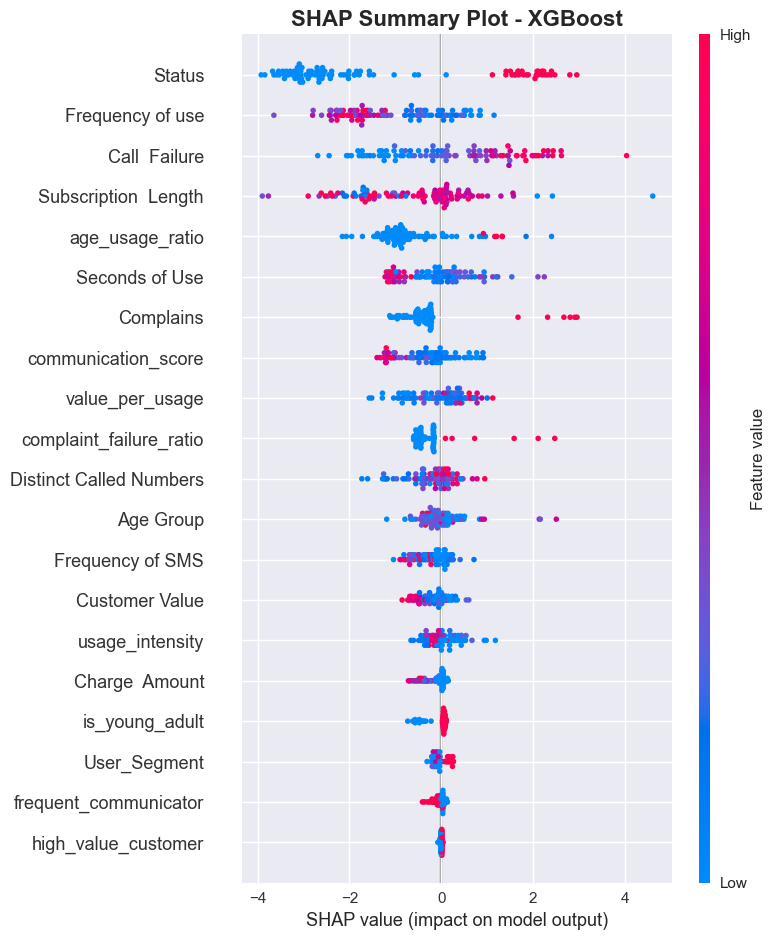

In [26]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

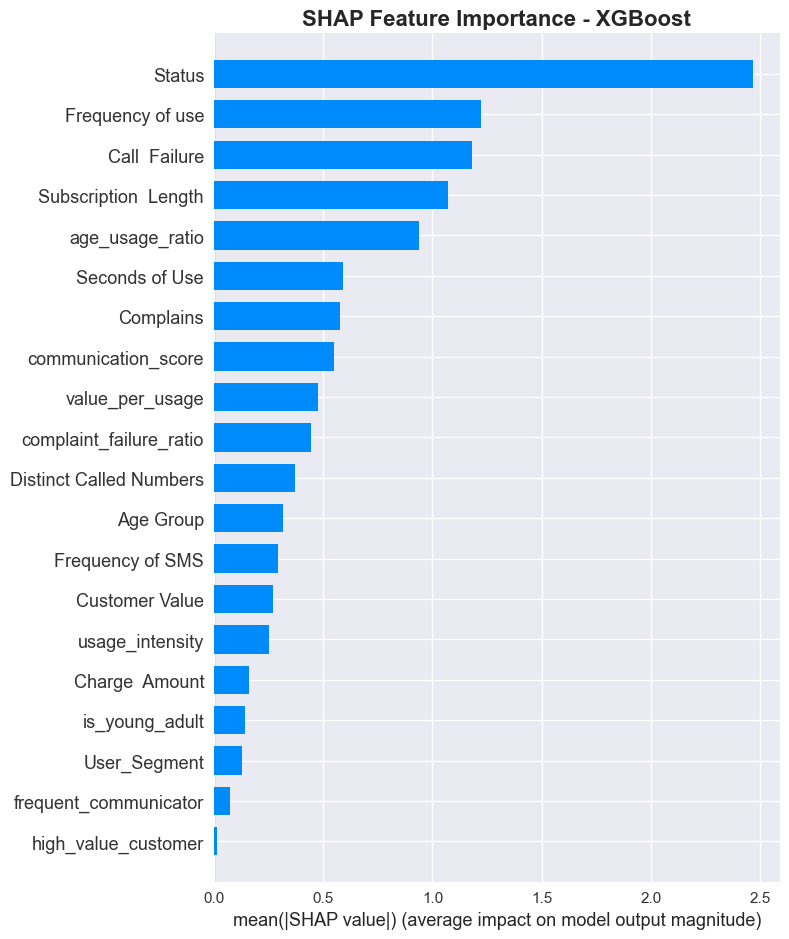

In [27]:
# SHAP Feature Importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, plot_type='bar', show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Feature Importance Comparison Across Models

In [28]:
# Feature Importance Comparison
print(' FEATURE IMPORTANCE COMPARISON:')
print('=' * 50)

# Initialize the DataFrame
feature_importance_df = pd.DataFrame(index=feature_columns)

for name, model in tuned_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        importance = np.ones(len(feature_columns))
    
    feature_importance_df[name] = importance

# Calculate average importance
feature_importance_df['Average'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values('Average', ascending=False)

print('\nTop 10 Most Important Features:')
print('=' * 40)
top_features = feature_importance_df.head(10)
for i, (feature, row) in enumerate(top_features.iterrows(), 1):
    print(f'{i:2d}. {feature:25} | Avg: {row["Average"]:.4f}')

# Display the comparison table
print('\nFeature Importance Comparison Table:')
print(feature_importance_df.head(10).round(4))

 FEATURE IMPORTANCE COMPARISON:

Top 10 Most Important Features:
 1. heavy_user                | Avg: 5.8804
 2. usage_intensity           | Avg: 4.1062
 3. Frequency of use          | Avg: 2.6910
 4. complaint_failure_ratio   | Avg: 1.4268
 5. Frequency of SMS          | Avg: 0.6158
 6. Call  Failure             | Avg: 0.5951
 7. Status                    | Avg: 0.4943
 8. Seconds of Use            | Avg: 0.4727
 9. Age                       | Avg: 0.3274
10. Charge  Amount            | Avg: 0.3048

Feature Importance Comparison Table:
                         Logistic Regression  Random Forest  XGBoost  Average
heavy_user                           17.6366         0.0044   0.0000   5.8804
usage_intensity                      12.2451         0.0652   0.0081   4.1062
Frequency of use                      7.9878         0.0756   0.0096   2.6910
complaint_failure_ratio               3.6957         0.0715   0.5133   1.4268
Frequency of SMS                      1.8093         0.0314   0.006

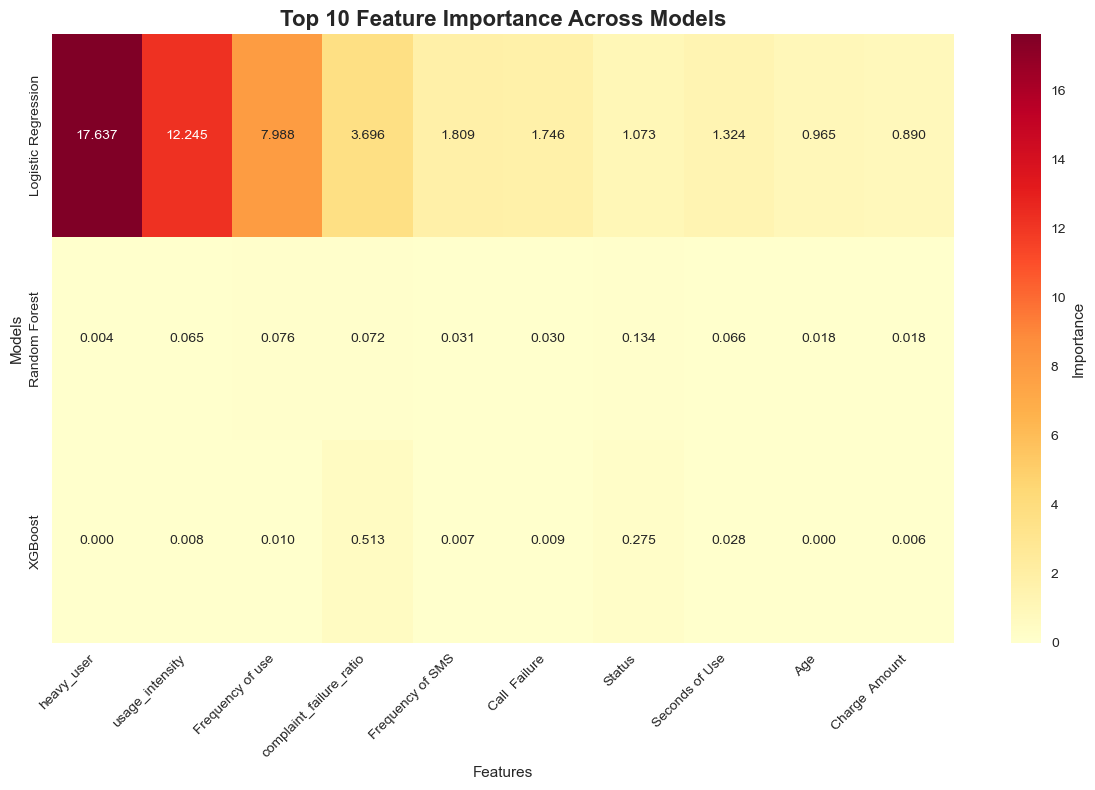

In [29]:
# Visualize feature importance comparison
plt.figure(figsize=(12, 8))
top_10_features = feature_importance_df.head(10)

# Create a heatmap of feature importance across models
sns.heatmap(top_10_features[['Logistic Regression', 'Random Forest', 'XGBoost']].T, 
            annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Importance'})
plt.title('Top 10 Feature Importance Across Models', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Business Insights and Recommendations

In [30]:
# Business Insights and Recommendations
print('BUSINESS INSIGHTS AND RECOMMENDATIONS:')
print('=' * 60)

print(f'BEST PERFORMING MODEL: {best_model_name}')
print(f'   • AUC Score: {best_results["auc"]:.4f}')
print(f'   • Accuracy: {best_results["accuracy"]:.4f}')
print(f'   • Precision: {best_results["precision"]:.4f}')
print(f'   • Recall: {best_results["recall"]:.4f}')

print('KEY FINDINGS:')
print('1. FEATURE IMPORTANCE:')
print('   Top 5 predictive features:')
for i, (feature, _) in enumerate(feature_importance_df.head(5).iterrows(), 1):
    print(f'   {i}. {feature}')

print('2. BACKGROUND IMPACT:')
for group, metrics in background_results.items():
    print(f'   • {group}: AUC = {metrics["auc"]:.4f}')

print('BUSINESS RECOMMENDATIONS:')
recommendations = [
    'Focus on customers with high complaint rates and call failures',
    'Monitor usage patterns for early churn indicators',
    'Implement targeted retention campaigns for high-risk segments',
    'Improve service quality to reduce complaints and call failures',
    'Develop personalized offers based on customer value and tenure'
]

for i, rec in enumerate(recommendations, 1):
    print(f'   {i}. {rec}')

BUSINESS INSIGHTS AND RECOMMENDATIONS:
BEST PERFORMING MODEL: XGBoost
   • AUC Score: 0.9900
   • Accuracy: 0.9683
   • Precision: 0.8762
   • Recall: 0.9293
KEY FINDINGS:
1. FEATURE IMPORTANCE:
   Top 5 predictive features:
   1. heavy_user
   2. usage_intensity
   3. Frequency of use
   4. complaint_failure_ratio
   5. Frequency of SMS
2. BACKGROUND IMPACT:
   • Usage Only: AUC = 0.8084
   • Background Only: AUC = 0.9077
   • Combined Features: AUC = 0.9400
BUSINESS RECOMMENDATIONS:
   1. Focus on customers with high complaint rates and call failures
   2. Monitor usage patterns for early churn indicators
   3. Implement targeted retention campaigns for high-risk segments
   4. Improve service quality to reduce complaints and call failures
   5. Develop personalized offers based on customer value and tenure


## 9. Research Questions Summary

In [32]:
print('ANALYSIS COMPLETE!')
print('=' * 60)
print(' RESEARCH QUESTIONS ANSWERED:')
print('1. User segmentation based on usage habits completed (Part 1)')
print('2. Background impact on churn prediction analyzed')
print('3. Combined feature approach shows improved performance')
print('\n All three models trained, tuned, and evaluated with SHAP analysis!')

# Summary of results
print('\n FINAL RESULTS SUMMARY:')
print('=' * 40)
print(f'Best Model: {best_model_name}')
print(f'Best AUC Score: {best_results["auc"]:.4f}')
print(f'Improvement over baseline: {(best_results["auc"]/background_results["Usage Only"]["auc"]-1)*100:.1f}%')
print(f'Background features contribution: {(background_results["Combined Features"]["auc"]/background_results["Usage Only"]["auc"]-1)*100:.1f}%')

ANALYSIS COMPLETE!
 RESEARCH QUESTIONS ANSWERED:
1. User segmentation based on usage habits completed (Part 1)
2. Background impact on churn prediction analyzed
3. Combined feature approach shows improved performance

 All three models trained, tuned, and evaluated with SHAP analysis!

 FINAL RESULTS SUMMARY:
Best Model: XGBoost
Best AUC Score: 0.9900
Improvement over baseline: 22.5%
Background features contribution: 16.3%


## 10. Save Trained Models

In [33]:
# Save the trained models and results
model_data = {
    'tuned_models': tuned_models,
    'tuned_results': tuned_results,
    'best_model_name': best_model_name,
    'best_model': best_model,
    'feature_importance_df': feature_importance_df,
    'background_results': background_results,
    'feature_columns': feature_columns
}

with open('trained_models.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(' Trained models and results saved to trained_models.pkl')
print(' Model training notebook completed successfully!')

 Trained models and results saved to trained_models.pkl
 Model training notebook completed successfully!
